## Question 3: What genetic alterations could improve your engineered cardiomyocytes?

In [1]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import celloracle as co

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
# Do setup
co.__version__

plt.rcParams["figure.figsize"] = [6,6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300

%matplotlib inline

# Make folders to save plots and links
im_folder = "co_figures"
link_folder = "co_links"

os.makedirs(im_folder, exist_ok=True)
os.makedirs(link_folder, exist_ok=True)

## Data preprocessing

1. Variable gene selection and normalization.

2. Log transformation. 

3. Cell clustering.

4. Dimensional reduction.

In [7]:
def preprocess_pipeline(adata,plot=False): 
    """
    This function preprocessing the scRNA-seq data
    
    """

    adata.var['mt']= adata.var_names.str.startswith(("mt-"))
    adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
    sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)
    # Filter out doublets
    thresh = np.percentile(adata.obs['total_counts'],95)
    adata = adata[adata.obs['total_counts'] < thresh, :]
    # Filter out low quality cells 
    adata = adata[adata.obs['pct_counts_mt'] < 5, :]
    adata = adata[adata.obs['pct_counts_ribo'] < 35, :]
    adata = adata[adata.obs['total_counts'] > 10000, :]
    ################################################################################
    # 1. filter out undetected genes that are expressed in less than 5 cells 
    sc.pp.filter_genes(adata, min_cells=5)
    ################################################################################
    # 2. Normalize gene expression matrix with total UMI count per cell
    sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')
    ################################################################################
    # 3. Identification of highly variable genes
    # Select top 2000 highly-variable genes
    filter_result = sc.pp.filter_genes_dispersion(adata.X,flavor='cell_ranger', n_top_genes=2000,log=False)
    # Subset the genes
    adata = adata[:, filter_result.gene_subset]
    # Renormalize after filtering
    sc.pp.normalize_per_cell(adata)
    ################################################################################
    # 4. Log Transform
    # keep raw cont data before log transformation
    adata.raw = adata
    adata.layers["raw_count"] = adata.raw.X.copy()
    # Log transformation and scaling
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    ################################################################################
    # 5. PCA and neighbor calculations
    sc.tl.pca(adata, svd_solver='arpack')
    # Diffusion map
    sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
    sc.tl.diffmap(adata)
    # Calculate neihbors again based on diffusionmap
    sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')
    ################################################################################
    # 6. cell clustering 
    sc.tl.louvain(adata, resolution=0.8)
    ################################################################################
    # 7. Dimensionality reduction using PAGA and force-directed graphs
    # PAGA graph construction
    sc.tl.paga(adata, groups='louvain')
    plt.rcParams["figure.figsize"] = [6, 4.5]
    sc.pl.paga(adata)
    sc.tl.draw_graph(adata, init_pos='paga', random_state=123)
    sc.pl.draw_graph(adata, color='louvain', legend_loc='on data')
    adata.write_h5ad("preprocessed_Kannan_perinatal_reference.h5ad")
    return adata

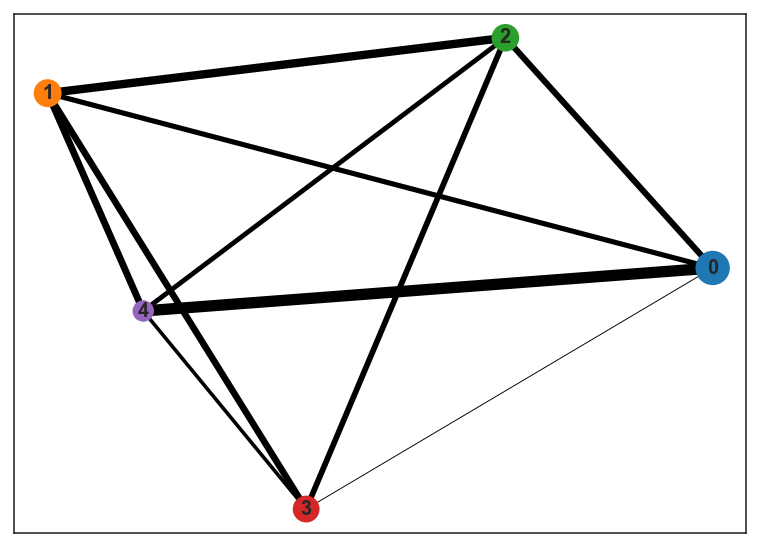

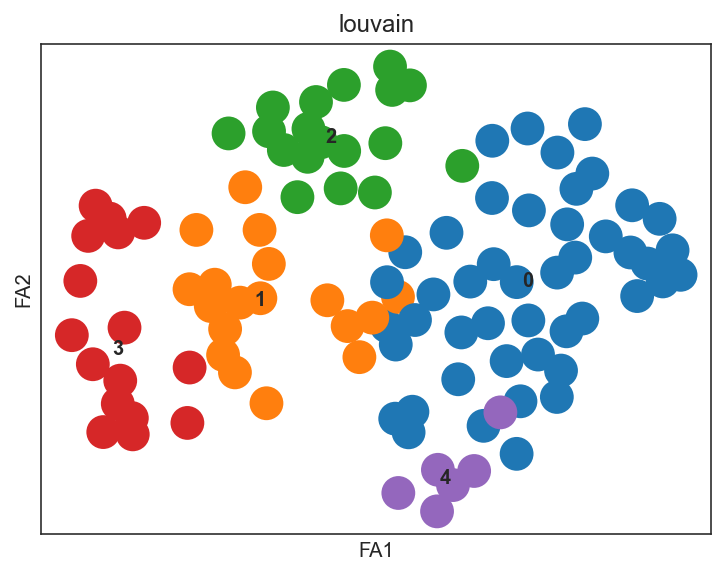

AnnData object with n_obs × n_vars = 105 × 1999
    obs: 'i7', 'cellbarcode', 'column', 'timepoint', 'genes', 'umis', 'ERCC_percent', 'reads', 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'n_counts_all', 'n_counts', 'louvain'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'diffmap_evals', 'louvain', 'paga', 'louvain_sizes', 'louvain_colors', 'draw_graph'
    obsm: 'X_pca', 'X_diffmap', 'X_draw_graph_fa'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

In [8]:
raw_adata = sc.read_h5ad("Kannan_perinatal_reference.h5ad")
preprocess_pipeline(adata=raw_adata)

## Create Oracle
We would like to turn everything in this section into a single callable function, taking the following inputs:


*   `h5ad` to preprocessed h5ad (QC, clustering, projection) *required*
*   `clusters` used for CellOracle regression *default: louvain*
*   `embedding` used for representation *default: X_pca*
*   `oracle_name` used for saving the oracle/links *default: oracle*

It will have no output, but will save 2 items in the folder it is run in:
*   `{oracle_name}.celloracle.oracle`
*   `{oracle_name}.celloracle.links`


In [9]:
h5ad = "preprocessed_Kannan_perinatal_reference.h5ad" #put file directory here
clusters = "louvain" #change if needed
embedding = "X_pca" #change if needed
oracle_name = "oracle"

adata = sc.read_h5ad(h5ad)
adata

# print("metadata columns :", list(adata.obs.columns))

AnnData object with n_obs × n_vars = 105 × 1999
    obs: 'i7', 'cellbarcode', 'column', 'timepoint', 'genes', 'umis', 'ERCC_percent', 'reads', 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'n_counts_all', 'n_counts', 'louvain'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'diffmap_evals', 'draw_graph', 'log1p', 'louvain', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'pca'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

In [10]:
#load GRN and create oracle
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
base_GRN.head()

oracle = co.Oracle()
oracle.import_anndata_as_raw_count(adata=adata.raw,
                                   cluster_column_name=clusters,
                                   embedding_name=embedding)
oracle.import_TF_data(TF_info_matrix=base_GRN)

AttributeError: 'Raw' object has no attribute 'obsm'

In [ ]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
print(n_comps)
n_comps = min(n_comps, 50)

In [ ]:
n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)
print(f"For {n_cell} cells, default k is :{k}")

oracle.knn_imputation(n_pca_dims=n_comps,
                      k=k,
                      balanced=True,
                      b_sight=k*8,
                      b_maxl=k*4,
                      n_jobs=8) #can change this

In [ ]:
#save
oracle.to_hdf5(f"{oracle_name}.celloracle.hdf5")
#load
#oracle = co.load_hdf5("oracle.celloracle.hdf5")

In [ ]:
warnings.filterwarnings('ignore') #Otherwise, np.int nightmare
links = oracle.get_links(cluster_name_for_GRN_unit=clusters,
                         alpha=10,
                         verbose_level=10)
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
links.get_network_score()

#save filtered links
for cluster in links.filtered_links.keys():
    links.links_dict[cluster].to_csv(f"{link_folder}/GRN_{cluster}.csv")

#save these as well.
links.to_hdf5(file_path=f"{oracle_name}.celloracle.links")

## Validation

In order to validate the effectiveness of CellOracle, we will train an oracle on the **Kannan** data and compare it to the **Prdm16-KO** data.

In [ ]:
#links = co.load_hdf5(file_path="links.celloracle.hdf5")
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10,
                              use_cluster_specific_TFdict=True)
gene = "Prdm16"
oracle.simulate_shift(perturb_condition={gene: 0.0},
                      n_propagation=3)
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

## Similarity measure
We will use 2D variable-wise Pearson Correlation for this.

For CellOracle validation, apply this to:

*   Kannan vs Prdm16-WT
*   Kannan (simulated Prdm16-KO) vs Prdm16-KO


After CellOracle is validated, train a SECOND oracle on the engineered cardiomyocytes (CM), and for EACH speculative shift, use pearson_corr to compare to each Kannan timepoint. Success will drive the shifted transcriptome as close to the final stage of differention as possible.

We can also use the Kannan entropy metric in addition to/instead of this.

In [ ]:
def pearson_corr(adata1, adata2):
    '''
    Calculate Pearson correlation of 2 anndata matrices
    
    Input:
    --------
    adata1: anndata object
    adata2: anndata object
    
    Output:
    --------
    float:
        Pearson correlation.
    '''
    #Extract matrices
    genes_list = numpy.union1d(adata1.var_names.tolist(),
                               adata2.var_names.tolist())

    A = adata1[:, genes_list].X
    B = adata2[:, genes_list].X

    A_mA = A - np.mean(A, axis=0)
    B_mB = B - np.mean(B, axis=0)

    # Sum of squares
    ssA = np.sum(np.power(A_mA, 2), axis=0)
    ssB = np.sum(np.power(A_mA, 2), axis=0)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))

## Gene Survey
Look at the top genes for the earliest and latest clusters.
We would like to improve on the effect by *repressing* the TFs most prominent in early cells and *expressing* the TFs most prominent in late cells. Pick, say, the top 20 differentially linked genes. These will be the shifts we test on the cardiomyocyte oracle.

In [ ]:
early_cluster = "FOO" #put Kannan early cluster name here
late_cluster = "BAR" #put Kannan late cluster name here

links.plot_score_comparison_2D(value,
                               early_cluster,
                               late_cluster,
                               percentile=99,
                               annot_shifts=None,
                               save=f"{imfolder}/score_comparison_{early_cluster}_{late_cluster}.png",
                               plt_show=True,
                               interactive=False)